# Making Pandas Fly

* Saving RAM
  * Categories including making faster queries
  * Smaller dtypes
* Pandas vs NumPy operations
* Numba for compilation
* Different ways to solve the same task

In [1]:
import numpy as np
import pandas as pd
import datetime
import random
import ipython_memory_usage
%ipython_memory_usage_start

'memory profile enabled'

In [1] used 0.1992 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 83.59 MiB


In [2]:
%load_ext watermark
%watermark -v -m -p pandas,numexpr

CPython 3.7.6
IPython 7.13.0

pandas 1.0.1
numexpr 2.7.1

compiler   : GCC 7.3.0
system     : Linux
release    : 5.3.0-46-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
In [2] used 4.2617 MiB RAM in 0.24s, peaked 0.00 MiB above current, total RAM usage 87.85 MiB


## Read _all_ data into RAM in one go

In [3]:
df_all = pd.read_pickle('merged_smaller.pickle.zip')
assert df_all[df_all.IncorporationDate.isna()].shape[0] == 0

In [3] used 804.9336 MiB RAM in 4.55s, peaked 238.04 MiB above current, total RAM usage 892.78 MiB


In [4]:
df = df_all
df.shape

(4593760, 3)

In [4] used -1.0938 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 891.69 MiB


In [5]:
df.head()

,CompanyName,CompanyStatus,IncorporationDate
CompanyNumber,,,
08209948,! LTD,Active,2012-09-11
11399177,!? LTD,Active,2018-06-05
11743365,!BIG IMPACT GRAPHICS LIMITED,Active,2018-12-28
12402527,!L PRODUCTIONS LIMITED,Active,2020-01-14
12234705,!NKED LTD,Active,2019-09-30


In [5] used 0.4336 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 892.12 MiB


# Categories

In [6]:
df.CompanyStatus.value_counts()

Active                                              4260241
Active - Proposal to Strike off                      171815
Liquidation                                           92551
Dissolved                                             62824
In Administration                                      3221
Live but Receiver Manager on at least one charge       1315
Voluntary Arrangement                                   955
In Administration/Administrative Receiver               324
RECEIVERSHIP                                            195
ADMINISTRATION ORDER                                    130
ADMINISTRATIVE RECEIVER                                 120
In Administration/Receiver Manager                       31
Converted / Closed                                       17
RECEIVER MANAGER / ADMINISTRATIVE RECEIVER               17
VOLUNTARY ARRANGEMENT / RECEIVER MANAGER                  3
VOLUNTARY ARRANGEMENT / ADMINISTRATIVE RECEIVER           1
Name: CompanyStatus, dtype: int64

In [6] used 0.0742 MiB RAM in 0.60s, peaked 0.00 MiB above current, total RAM usage 892.20 MiB


In [7]:
df.CompanyStatus.memory_usage()

73500160

In [7] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 892.20 MiB


In [8]:
df['CompanyStatus_cat'] = df.CompanyStatus.astype('category')

In [8] used 0.2383 MiB RAM in 0.50s, peaked 58.02 MiB above current, total RAM usage 892.43 MiB


In [9]:
df['CompanyStatus_cat'].value_counts()

Active                                              4260241
Active - Proposal to Strike off                      171815
Liquidation                                           92551
Dissolved                                             62824
In Administration                                      3221
Live but Receiver Manager on at least one charge       1315
Voluntary Arrangement                                   955
In Administration/Administrative Receiver               324
RECEIVERSHIP                                            195
ADMINISTRATION ORDER                                    130
ADMINISTRATIVE RECEIVER                                 120
In Administration/Receiver Manager                       31
RECEIVER MANAGER / ADMINISTRATIVE RECEIVER               17
Converted / Closed                                       17
VOLUNTARY ARRANGEMENT / RECEIVER MANAGER                  3
VOLUNTARY ARRANGEMENT / ADMINISTRATIVE RECEIVER           1
Name: CompanyStatus_cat, dtype: int64

In [9] used 0.0938 MiB RAM in 0.18s, peaked 0.00 MiB above current, total RAM usage 892.53 MiB


In [10]:
df['CompanyStatus_cat'].memory_usage()

41344608

In [10] used 0.1016 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 892.63 MiB


In [11]:
df['CompanyStatus_cat'].cat.categories

Index(['ADMINISTRATION ORDER', 'ADMINISTRATIVE RECEIVER', 'Active',
       'Active - Proposal to Strike off', 'Converted / Closed', 'Dissolved',
       'In Administration', 'In Administration/Administrative Receiver',
       'In Administration/Receiver Manager', 'Liquidation',
       'Live but Receiver Manager on at least one charge',
       'RECEIVER MANAGER / ADMINISTRATIVE RECEIVER', 'RECEIVERSHIP',
       'VOLUNTARY ARRANGEMENT / ADMINISTRATIVE RECEIVER',
       'VOLUNTARY ARRANGEMENT / RECEIVER MANAGER', 'Voluntary Arrangement'],
      dtype='object')

In [11] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 892.63 MiB


In [12]:
df['CompanyStatus_cat'].cat.codes

CompanyNumber
08209948    2
11399177    2
11743365    2
12402527    2
12234705    2
           ..
11558494    5
11557513    5
12547694    2
11485704    5
11637310    5
Length: 4593760, dtype: int8

In [12] used 152.6641 MiB RAM in 4.12s, peaked 0.00 MiB above current, total RAM usage 1045.29 MiB


In [13]:
%timeit df['CompanyStatus'].value_counts()

484 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [13] used 0.0898 MiB RAM in 4.01s, peaked 0.00 MiB above current, total RAM usage 1045.38 MiB


In [14]:
%timeit df['CompanyStatus_cat'].value_counts() # HUGE SAVING

37.6 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
In [14] used 0.0469 MiB RAM in 3.38s, peaked 35.03 MiB above current, total RAM usage 1045.43 MiB


In [15]:
df2_cat = df.set_index('CompanyStatus_cat')
df2_nocat = df.set_index('CompanyStatus')

In [15] used 245.3516 MiB RAM in 0.53s, peaked 0.00 MiB above current, total RAM usage 1290.78 MiB


## Make a mask for a query on the index

In [16]:
%timeit (df2_cat.index == 'Liquidation')

848 µs ± 584 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
In [16] used 0.0195 MiB RAM in 0.93s, peaked 0.00 MiB above current, total RAM usage 1290.80 MiB


In [17]:
%timeit (df2_nocat.index == 'Liquidation')

271 ms ± 8.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [17] used 0.0000 MiB RAM in 2.27s, peaked 0.00 MiB above current, total RAM usage 1290.80 MiB


# Make a new column

Which `dtype` is best to use? How small can we go?

In [18]:
now = datetime.datetime.now()
age_deltas = now - df.IncorporationDate
df['age_years'] = age_deltas.dt.days / 360

In [18] used 70.1719 MiB RAM in 0.37s, peaked 0.00 MiB above current, total RAM usage 1360.97 MiB


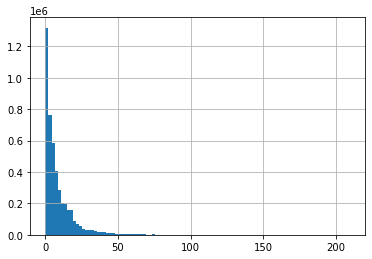

In [19] used 14.6602 MiB RAM in 1.16s, peaked 34.26 MiB above current, total RAM usage 1375.63 MiB


In [19]:
df['age_years'].hist(bins=100);

In [20]:
df.age_years.describe()

count    4.593760e+06
mean     8.766208e+00
std      1.157942e+01
min      1.666667e-02
25%      1.777778e+00
50%      4.955556e+00
75%      1.132500e+01
max      2.094806e+02
Name: age_years, dtype: float64

In [20] used 0.3867 MiB RAM in 0.41s, peaked 102.87 MiB above current, total RAM usage 1376.02 MiB


In [21]:
df['age_years_smaller'] = df.age_years.astype("float32")
df['age_years'].describe()

count    4.593760e+06
mean     8.766208e+00
std      1.157942e+01
min      1.666667e-02
25%      1.777778e+00
50%      4.955556e+00
75%      1.132500e+01
max      2.094806e+02
Name: age_years, dtype: float64

In [21] used 15.7422 MiB RAM in 0.47s, peaked 73.02 MiB above current, total RAM usage 1391.76 MiB


In [22]:
df[['age_years', 'age_years_smaller']].memory_usage()

Index                204522240
age_years             36750080
age_years_smaller     18375040
dtype: int64

In [22] used 0.0117 MiB RAM in 0.16s, peaked 0.00 MiB above current, total RAM usage 1391.77 MiB


In [23]:
ser = df.age_years 
print(f"Range {ser.min():0.4f} - {ser.max():0.4f}, {ser.dtype} {ser.nbytes:,}")
ser = ser.astype("float32")
print(f"Range {ser.min():0.4f} - {ser.max():0.4f}, {ser.dtype} {ser.nbytes:,}")
ser = ser.astype("float16") # NOTE hardware _interpreted_ so slow
print(f"Range {ser.min():0.4f} - {ser.max():0.4f}, {ser.dtype} {ser.nbytes:,}")

Range 0.0167 - 209.4806, float64 36,750,080
Range 0.0167 - 209.4806, float32 18,375,040
Range 0.0167 - 209.5000, float16 9,187,520
In [23] used 21.8438 MiB RAM in 0.34s, peaked 13.20 MiB above current, total RAM usage 1413.62 MiB


In [24]:
# let's assume you just wanted the status & age columns
df_original_ram = df[['CompanyStatus', 'age_years']]
df_original_ram.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 4593760 entries, 08209948 to 11637310
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   CompanyStatus  object 
 1   age_years      float64
dtypes: float64(1), object(1)
memory usage: 760.6 MB
In [24] used 70.1484 MiB RAM in 21.90s, peaked 0.00 MiB above current, total RAM usage 1483.77 MiB


In [25]:
df_smaller_ram = df[['CompanyStatus_cat', 'age_years_smaller']]
df_smaller_ram.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 4593760 entries, 08209948 to 11637310
Data columns (total 2 columns):
 #   Column             Dtype   
---  ------             -----   
 0   CompanyStatus_cat  category
 1   age_years_smaller  float32 
dtypes: category(1), float32(1)
memory usage: 466.7 MB
In [25] used 4.2656 MiB RAM in 11.73s, peaked 0.00 MiB above current, total RAM usage 1488.03 MiB


# Query speeds

In [26]:
target_age = 5
df.query('age_years < @target_age').shape

(2308970, 6)

In [26] used 0.4062 MiB RAM in 0.76s, peaked 87.75 MiB above current, total RAM usage 1488.44 MiB


In [27]:
%timeit df.query('age_years < 5')

796 ms ± 200 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [27] used 0.0000 MiB RAM in 6.83s, peaked 87.93 MiB above current, total RAM usage 1488.44 MiB


In [28]:
%timeit df[df['age_years'] < 5] #  base case for Pandas lookups

409 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [28] used 0.0508 MiB RAM in 3.28s, peaked 87.93 MiB above current, total RAM usage 1488.49 MiB


In [29]:
assert df.query('age_years < @target_age').shape == df[df['age_years'] < 5].shape

In [29] used 0.0000 MiB RAM in 1.05s, peaked 87.93 MiB above current, total RAM usage 1488.49 MiB


# NumPy vs Pandas operations

Go to slides to discuss the overheads...

In [30]:
%%timeit 
df['age_years'].sum()

27.7 ms ± 895 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
In [30] used 0.0078 MiB RAM in 2.35s, peaked 35.03 MiB above current, total RAM usage 1488.50 MiB


In [31]:
%%timeit 
df['age_years'].values.sum()

2.91 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
In [31] used 0.0000 MiB RAM in 2.70s, peaked 0.00 MiB above current, total RAM usage 1488.50 MiB


# More than one way to solve a task

We can't use Numba as Numba doesn't make strings go any faster

In [37]:
df.sort_index().CompanyName.str.count(" ").head()

CompanyNumber
00000086    2
00000118    4
00000121    3
00000133    5
00000140    5
Name: CompanyName, dtype: int64

In [37] used 157.6602 MiB RAM in 20.80s, peaked 17.65 MiB above current, total RAM usage 1708.03 MiB


In [38]:
%timeit df.CompanyName.str.count(" ")

3.69 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [38] used 0.0000 MiB RAM in 29.96s, peaked 35.06 MiB above current, total RAM usage 1708.03 MiB


In [39]:
%timeit df.CompanyName.apply(lambda s: s.count(" "))

2.34 s ± 56.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [39] used 0.0000 MiB RAM in 18.83s, peaked 69.88 MiB above current, total RAM usage 1708.03 MiB


# Numba

In [32]:
def won_the_lottery(age):
    """Older companies have a higher chance 
       of winning a low-probability event"""
    for n in range(int(age)):
        if random.uniform(0, 1) > 0.9:
            return True
    return False
df_sample = df.sample(5)
ser = df_sample['age_years'].apply(won_the_lottery) # example output
ser.name = 'won_lottery'
pd.concat((df_sample, ser), axis=1)

,CompanyName,CompanyStatus,IncorporationDate,CompanyStatus_cat,age_years,age_years_smaller,won_lottery
CompanyNumber,,,,,,,
03110908,THE RCJ AND ISLINGTON CITIZENS ADVICE BUREAUX,Active,1995-10-06,Active,24.916667,24.916666,True
NI633361,EURO GOLD FIELD LTD,Active,2015-09-02,Active,4.719444,4.719444,True
12108269,ABSOLUTE GARDENS MAINTENANCE LTD,Active,2019-07-17,Active,0.791667,0.791667,False
05732882,R GAMBLE HOLDINGS LIMITED,Active,2006-03-07,Active,14.347222,14.347222,False
04378340,PRAGUE SHOES LTD,Active,2002-02-20,Active,18.447222,18.447222,True


In [32] used 0.0859 MiB RAM in 0.34s, peaked 3.01 MiB above current, total RAM usage 1488.58 MiB


In [33]:
%timeit df['age_years'].apply(won_the_lottery) 

9.43 s ± 243 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [33] used 1.7422 MiB RAM in 75.11s, peaked 209.86 MiB above current, total RAM usage 1490.32 MiB


In [34]:
from numba import njit
@njit()
def won_the_lottery(age):
    """Older companies have a higher chance 
       of winning a low-probability event"""
    for n in range(int(age)):
        if random.uniform(0, 1) > 0.9:
            return True
    return False
df.sample(5)['age_years'].apply(won_the_lottery) # pre-compile to stabilise timing

CompanyNumber
05814632     True
10141470    False
06901658     True
08868758    False
09739132    False
Name: age_years, dtype: bool

In [34] used 59.0117 MiB RAM in 0.86s, peaked 0.00 MiB above current, total RAM usage 1549.34 MiB


In [35]:
%timeit df['age_years'].apply(won_the_lottery) 

1.96 s ± 62.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
In [35] used 1.0117 MiB RAM in 15.94s, peaked 211.61 MiB above current, total RAM usage 1550.35 MiB


In [36]:
won_the_lottery.inspect_types()

won_the_lottery (float64,)
--------------------------------------------------------------------------------
# File: <ipython-input-34-62651dd83ff1>
# --- LINE 2 --- 

@njit()

# --- LINE 3 --- 

def won_the_lottery(age):

    # --- LINE 4 --- 

    """Older companies have a higher chance

       # --- LINE 5 --- 

       of winning a low-probability event"""

    # --- LINE 6 --- 
    # label 0
    #   age = arg(0, name=age)  :: float64
    #   jump 2
    # label 2
    #   $4load_global.0 = global(range: <class 'range'>)  :: Function(<class 'range'>)
    #   $6load_global.1 = global(int: <class 'int'>)  :: Function(<class 'int'>)
    #   $10call_function.3 = call $6load_global.1(age, func=$6load_global.1, args=[Var(age, <ipython-input-34-62651dd83ff1>:6)], kws=(), vararg=None)  :: (float64,) -> int64
    #   del age
    #   del $6load_global.1
    #   $12call_function.4 = call $4load_global.0($10call_function.3, func=$4load_global.0, args=[Var($10call_function.3, <ipython-input-34-6265